## Creating a dataset

The main purpose of this notebook is to combine a few datasets of interest to our project into a single one with the aim of creating a minimal working example and a baseline model. I had to make some options throughout the process, and some have some shortcomings that we will have to address. For instance, I am using all the data available for a given street when creating a model, but some features of a street change with time (perhaps some speed humps were installed last year in the street we are studying). Any model based on the dataset created in this notebook will ignore this considerations. 

The baseline model and MWE will both try to estimate the number of crashes occurring in a given street of NYC, at a given time of day during the period of one month.

The most important data sources are the files `crashes_20240316.csv` and `centerline.geojson` in the `data` folder. The former lists all reported crashes occurring in New York city since July 2012, while the latter is a list of NYC streets along with some properties. We can use GeoPandas to join them: `crashes` comes with latitutde and longitude, while `centerline` has a `geometry` feature that outlines the roads on a map.

In [44]:
import pandas as pd
import numpy as np

In [45]:
NYC_EPSG = "EPSG:2263"
STD_EPSG = "EPSG:4326"

In [46]:
from pathlib import Path

DATA_FOLDER = Path("./data")

In [47]:
CRASHES_DATASET = DATA_FOLDER / "crashes_20240316.csv"
CENTERLINE_DATASET = DATA_FOLDER / "centerline.geojson"
SPEEDLIMS_DATASET = DATA_FOLDER / "speedlimits.geojson"
HUMPS_DATASET = DATA_FOLDER / "humps.geojson"

In [48]:
crashes = pd.read_csv(CRASHES_DATASET)
crashes.head()

/tmp/ipykernel_218328/3195495548.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  crashes = pd.read_csv(CRASHES_DATASET)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


For the sake of this example, I will only keep a few columns. There are several other features of this dataset that we may be interested about. For instance, we may want to know how many people died in a given car crash so that we can rank each in terms of its severity.

In [49]:
columns_to_keep = ["CRASH DATE", "CRASH TIME", "LATITUDE", "LONGITUDE"]

In [50]:
crashes_eda = crashes[columns_to_keep]

In [51]:
crashes.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072951 entries, 0 to 2072950
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   CRASH DATE                     2072951 non-null  object 
 1   CRASH TIME                     2072951 non-null  object 
 2   BOROUGH                        1427992 non-null  object 
 3   ZIP CODE                       1427742 non-null  object 
 4   LATITUDE                       1839466 non-null  float64
 5   LONGITUDE                      1839466 non-null  float64
 6   LOCATION                       1839466 non-null  object 
 7   ON STREET NAME                 1633104 non-null  object 
 8   CROSS STREET NAME              1289811 non-null  object 
 9   OFF STREET NAME                347474 non-null   object 
 10  NUMBER OF PERSONS INJURED      2072933 non-null  float64
 11  NUMBER OF PERSONS KILLED       2072920 non-null  float64
 12  NUMBER OF PEDE

We can only work with rows with non-null latitude and longitude entries.

In [52]:
crashes_eda = crashes_eda.dropna(subset=["LONGITUDE", "LATITUDE"])
crashes_eda.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1839466 entries, 3 to 2072950
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   CRASH DATE  1839466 non-null  object 
 1   CRASH TIME  1839466 non-null  object 
 2   LATITUDE    1839466 non-null  float64
 3   LONGITUDE   1839466 non-null  float64
dtypes: float64(2), object(2)
memory usage: 70.2+ MB


In [53]:
import datetime


def create_datetime_feature(row: pd.DataFrame) -> datetime.datetime:
    month, day, year = list(map(int, row["CRASH DATE"].split("/")))
    hour, minute = list(map(int, row["CRASH TIME"].split(":")))
    return datetime.datetime(year, month, day, hour, minute)

In [54]:
crashes_eda["DATETIME"] = crashes_eda[["CRASH DATE", "CRASH TIME"]].apply(
    create_datetime_feature, axis=1
)

In [55]:
crashes_eda.drop(columns=["CRASH DATE", "CRASH TIME"], inplace=True)

In [56]:
import geopandas as gpd

centerline = gpd.read_file(CENTERLINE_DATASET)
speed_lims = gpd.read_file(SPEEDLIMS_DATASET)
humps = gpd.read_file(HUMPS_DATASET)

In [57]:
centerline_cols_keep = [
    "rw_type",
    "bike_lane",
    "shape_leng",
    "trafdir",
    "geometry",
    "st_width",
]
centerline = centerline[centerline_cols_keep]

In [58]:
centerline.geometry.value_counts()

geometry
MULTILINESTRING ((-73.94652 40.75345, -73.9463...    2
MULTILINESTRING ((-73.94729 40.75378, -73.9465...    2
MULTILINESTRING ((-74.01905 40.63670, -74.0189...    2
MULTILINESTRING ((-73.95977 40.81876, -73.9593...    2
MULTILINESTRING ((-73.95857 40.75884, -73.9585...    2
                                                    ..
MULTILINESTRING ((-74.01151 40.70296, -74.0111...    1
MULTILINESTRING ((-73.91100 40.88212, -73.9108...    1
MULTILINESTRING ((-73.89560 40.88509, -73.8955...    1
MULTILINESTRING ((-73.89566 40.88528, -73.8956...    1
MULTILINESTRING ((-73.90943 40.88265, -73.9094...    1
Name: count, Length: 121427, dtype: int64

There are several duplicated roads in the `centerline` dataset. Perhaps each corresponds to a direction of traffic? For now, I will only keep the first one.

In [59]:
centerline = centerline.drop_duplicates(subset=["geometry"])

In [60]:
centerline.to_crs(NYC_EPSG, inplace=True)
speed_lims.to_crs(NYC_EPSG, inplace=True)
humps.to_crs(NYC_EPSG, inplace=True)
speed_lims["centroid"] = speed_lims.geometry.centroid

In [61]:
speed_lims.rename(
    columns={"geometry": "road_geom", "centroid": "geometry"}, inplace=True
)

In [62]:
centerline["buffered"] = centerline.geometry.buffer(32)
centerline.rename(
    columns={"geometry": "road_geom", "buffered": "geometry"}, inplace=True
)

In [63]:
road_info = centerline.sjoin(speed_lims, how="left")

In [64]:
road_info.drop(
    columns=["shape_leng_right", "road_geom_right", "index_right"], inplace=True
)
road_info.rename(
    columns={"shape_leng_left": "shape_leng", "road_geom_left": "road_geom"},
    inplace=True,
)

In [65]:
road_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 260941 entries, 0 to 121655
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   rw_type     260941 non-null  object  
 1   bike_lane   35822 non-null   object  
 2   shape_leng  260941 non-null  object  
 3   trafdir     260902 non-null  object  
 4   road_geom   260941 non-null  geometry
 5   st_width    260941 non-null  object  
 6   geometry    260941 non-null  geometry
 7   postvz_sg   247441 non-null  object  
 8   postvz_sl   247441 non-null  object  
 9   street      247441 non-null  object  
dtypes: geometry(2), object(8)
memory usage: 21.9+ MB


For the moment, I will fill null values in the speed limit column with the mode.

In [66]:
speed_lim_mode = road_info.postvz_sl.mode().iloc[0]
speed_lim_mode

'25'

In [67]:
road_info["postvz_sl"] = road_info["postvz_sl"].fillna(speed_lim_mode)

In [68]:
road_info["postvz_sl"] = road_info["postvz_sl"].astype(int)

In [69]:
road_info = road_info.groupby(
    by=[
        "rw_type",
        "bike_lane",
        "shape_leng",
        "trafdir",
        "geometry",
        "road_geom",
        "st_width",
    ],
    dropna=False,
    as_index=False,
)["postvz_sl"].mean()

In [70]:
road_info.columns

Index(['rw_type', 'bike_lane', 'shape_leng', 'trafdir', 'geometry',
       'road_geom', 'st_width', 'postvz_sl'],
      dtype='object')

In [71]:
humps = humps[["humps", "geometry"]]

In [72]:
road_info = gpd.GeoDataFrame(road_info, geometry=road_info.geometry, crs=NYC_EPSG)

In [73]:
humps["centroid"] = humps["geometry"].centroid
humps.rename(columns={"geometry": "road_geom", "centroid": "geometry"}, inplace=True)
humps.drop(columns=["road_geom"], inplace=True)

In [74]:
road_info = road_info.sjoin(humps, how="left")

In [75]:
road_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 121563 entries, 0 to 121426
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   rw_type      121563 non-null  object  
 1   bike_lane    15685 non-null   object  
 2   shape_leng   121563 non-null  object  
 3   trafdir      121553 non-null  object  
 4   geometry     121563 non-null  geometry
 5   road_geom    121563 non-null  geometry
 6   st_width     121563 non-null  object  
 7   postvz_sl    121563 non-null  float64 
 8   index_right  4194 non-null    float64 
 9   humps        4194 non-null    object  
dtypes: float64(2), geometry(2), object(6)
memory usage: 10.2+ MB


In [76]:
road_info.road_geom.value_counts()

road_geom
MULTILINESTRING ((1033693.814 151394.453, 1033...    3
MULTILINESTRING ((1033738.440 151364.312, 1033...    3
MULTILINESTRING ((1038917.563 153012.307, 1038...    3
MULTILINESTRING ((1064548.187 210853.361, 1064...    3
MULTILINESTRING ((1033281.328 151208.919, 1033...    3
                                                    ..
MULTILINESTRING ((1026875.484 208891.584, 1026...    1
MULTILINESTRING ((1010806.216 218841.206, 1010...    1
MULTILINESTRING ((982926.152 187113.168, 98295...    1
MULTILINESTRING ((1000398.681 248722.021, 1000...    1
MULTILINESTRING ((1039256.594 184744.169, 1039...    1
Name: count, Length: 121427, dtype: int64

In [77]:
columns_to_groupby = list(road_info.columns)
columns_to_groupby.remove("index_right")
columns_to_groupby.remove("humps")
columns_to_groupby

['rw_type',
 'bike_lane',
 'shape_leng',
 'trafdir',
 'geometry',
 'road_geom',
 'st_width',
 'postvz_sl']

In [79]:
road_info["humps"] = road_info["humps"].fillna(0)
road_info["humps"] = road_info["humps"].astype(float)

In [80]:
road_info = road_info.groupby(by=columns_to_groupby, as_index=False, dropna=False)[
    "humps"
].sum()

In [82]:
road_info.humps.value_counts()

humps
0.0    117369
1.0      2623
2.0      1118
3.0       189
4.0        87
9.0        16
5.0         9
8.0         8
6.0         8
Name: count, dtype: int64

In [83]:
road_info = gpd.GeoDataFrame(road_info, geometry=road_info.geometry, crs=NYC_EPSG)

In [84]:
road_info.road_geom.value_counts()

road_geom
MULTILINESTRING ((963341.333 173402.966, 96328...    1
MULTILINESTRING ((1033288.969 251636.684, 1033...    1
MULTILINESTRING ((993165.517 198810.190, 99316...    1
MULTILINESTRING ((982782.907 198677.700, 98279...    1
MULTILINESTRING ((934739.005 166936.419, 93474...    1
                                                    ..
MULTILINESTRING ((1015581.752 267292.839, 1015...    1
MULTILINESTRING ((983378.113 198714.222, 98340...    1
MULTILINESTRING ((983470.612 186474.070, 98351...    1
MULTILINESTRING ((974902.903 160965.516, 97490...    1
MULTILINESTRING ((1025923.485 240757.785, 1026...    1
Name: count, Length: 121427, dtype: int64

In [85]:
road_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 121427 entries, 0 to 121426
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   rw_type     121427 non-null  object  
 1   bike_lane   15670 non-null   object  
 2   shape_leng  121427 non-null  object  
 3   trafdir     121417 non-null  object  
 4   geometry    121427 non-null  geometry
 5   road_geom   121427 non-null  geometry
 6   st_width    121427 non-null  object  
 7   postvz_sl   121427 non-null  float64 
 8   humps       121427 non-null  float64 
dtypes: float64(2), geometry(2), object(5)
memory usage: 8.3+ MB


In [86]:
crashes_gdf = gpd.GeoDataFrame(
    crashes_eda,
    geometry=gpd.points_from_xy(crashes_eda["LONGITUDE"], crashes_eda["LATITUDE"]),
    crs=STD_EPSG,
)

In [87]:
road_info = gpd.GeoDataFrame(road_info, geometry=road_info.geometry, crs=NYC_EPSG)

In [88]:
crashes_gdf.to_crs(NYC_EPSG, inplace=True)

In [89]:
crashes_road = road_info.sjoin(crashes_gdf, how="left")

In [90]:
crashes_road.info(show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6254343 entries, 0 to 121426
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   rw_type      6254343 non-null  object        
 1   bike_lane    1268397 non-null  object        
 2   shape_leng   6254343 non-null  object        
 3   trafdir      6253803 non-null  object        
 4   geometry     6254343 non-null  geometry      
 5   road_geom    6254343 non-null  geometry      
 6   st_width     6254343 non-null  object        
 7   postvz_sl    6254343 non-null  float64       
 8   humps        6254343 non-null  float64       
 9   index_right  6231038 non-null  float64       
 10  LATITUDE     6231038 non-null  float64       
 11  LONGITUDE    6231038 non-null  float64       
 12  DATETIME     6231038 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), geometry(2), object(5)
memory usage: 668.0+ MB


In [91]:
crashes_road.drop(columns=["index_right"], inplace=True)

In [92]:
crashes_road.reset_index(inplace=True)
crashes_road.drop(columns=["index"], inplace=True)

In [93]:
del crashes_gdf, crashes_eda, humps, road_info, centerline

In [94]:
crashes_road.head()

,rw_type,bike_lane,shape_leng,trafdir,geometry,road_geom,st_width,postvz_sl,humps,LATITUDE,LONGITUDE,DATETIME
0,1,1,10.4998278111,TF,"POLYGON ((993192.181 198789.615, 993190.989 19...","MULTILINESTRING ((993165.517 198810.190, 99316...",40.0,25.0,0.0,NaN,NaN,NaT
1,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2021-07-25 12:23:00
2,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2022-02-03 14:13:00
3,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2022-02-17 04:46:00
4,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2023-09-25 20:45:00


In [95]:
crashes_road["month"] = crashes_road.DATETIME.apply(lambda o: o.month)

In [96]:
crashes_road["hour"] = crashes_road.DATETIME.apply(lambda o: o.hour)

In [97]:
crashes_road["year"] = crashes_road.DATETIME.apply(lambda o: o.year)

In [98]:
crashes_road.info(show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6254343 entries, 0 to 6254342
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   rw_type     6254343 non-null  object        
 1   bike_lane   1268397 non-null  object        
 2   shape_leng  6254343 non-null  object        
 3   trafdir     6253803 non-null  object        
 4   geometry    6254343 non-null  geometry      
 5   road_geom   6254343 non-null  geometry      
 6   st_width    6254343 non-null  object        
 7   postvz_sl   6254343 non-null  float64       
 8   humps       6254343 non-null  float64       
 9   LATITUDE    6231038 non-null  float64       
 10  LONGITUDE   6231038 non-null  float64       
 11  DATETIME    6231038 non-null  datetime64[ns]
 12  month       6231038 non-null  float64       
 13  hour        6231038 non-null  float64       
 14  year        6231038 non-null  float64       
dtypes: datetime64[ns](1), fl

<Axes: xlabel='month', ylabel='hour'>

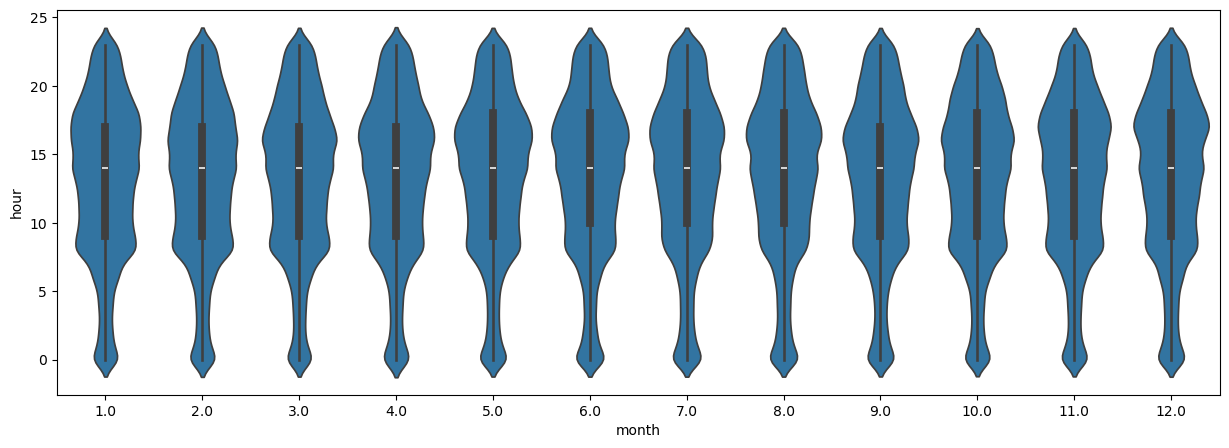

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
sns.violinplot(
    crashes_road.dropna(subset=["month"]), x="month", y="hour", bw_adjust=1.5
)

The distribution of crashes in NYC during the day does not change much from month to month, but it is clear that there are more crashes during peak times.

In [100]:
number_of_months = len(crashes_road[["month", "year"]].drop_duplicates())
number_of_months

142

In [101]:
crashes_road.columns
columns_to_grouby = [
    "rw_type",
    "bike_lane",
    "shape_leng",
    "trafdir",
    "geometry",
    "road_geom",
    "st_width",
    "postvz_sl",
    "humps",
    "hour",
]

In [102]:
crashes_road["crashes"] = crashes_road.hour.apply(lambda o: not np.isnan(o))

In [103]:
crashes_road_hour_count = crashes_road.groupby(
    by=columns_to_grouby, as_index=False, dropna=False
)["crashes"].sum()

In [104]:
del crashes_road

In [105]:
crashes_road_hour_count.sort_values("crashes", ascending=False)

,rw_type,bike_lane,shape_leng,trafdir,geometry,road_geom,st_width,postvz_sl,humps,hour,crashes
970261,1,NaN,474.559662707,TW,"POLYGON ((1012988.272 185000.542, 1012988.723 ...","MULTILINESTRING ((1012865.703 185460.115, 1012...",60.0,25.0,0.0,16.0,124
1127121,1,NaN,6528.61031702,TW,"POLYGON ((1019937.337 260087.035, 1019937.418 ...","MULTILINESTRING ((1019758.386 259418.315, 1019...",54.0,25.0,0.0,8.0,122
1183010,1,NaN,718.071632481,FT,"POLYGON ((994151.618 216413.573, 994154.291 21...","MULTILINESTRING ((993507.232 216732.034, 99413...",35.0,25.0,0.0,17.0,120
1127130,1,NaN,6528.61031702,TW,"POLYGON ((1019937.337 260087.035, 1019937.418 ...","MULTILINESTRING ((1019758.386 259418.315, 1019...",54.0,25.0,0.0,17.0,116
1022766,1,NaN,524.287333558,TW,"POLYGON ((1012888.646 185509.624, 1012889.094 ...","MULTILINESTRING ((1012757.078 186018.143, 1012...",60.0,25.0,0.0,16.0,110
...,...,...,...,...,...,...,...,...,...,...,...
1428137,8,NaN,109.35064386,TW,"POLYGON ((1047880.540 191150.009, 1047852.751 ...","MULTILINESTRING ((1047883.568 191212.696, 1047...",24.0,25.0,0.0,NaN,0
1428138,8,NaN,1096.35845777,TW,"POLYGON ((929568.749 150840.832, 929565.612 15...","MULTILINESTRING ((930665.015 150875.870, 92956...",46.0,25.0,0.0,NaN,0
1428140,8,NaN,111.206388612,TW,"POLYGON ((963410.107 166583.696, 963412.807 16...","MULTILINESTRING ((963412.444 166543.028, 96343...",20.0,25.0,0.0,NaN,0
1428141,8,NaN,111.515275033,TW,"POLYGON ((1016050.739 146141.524, 1016053.778 ...","MULTILINESTRING ((1015953.941 146077.573, 1016...",12.0,25.0,0.0,NaN,0


In [106]:
crashes_road_hour_count["crashes"] = (
    crashes_road_hour_count["crashes"] / number_of_months
)

In [107]:
crashes_road_hour_count.drop(columns=["geometry", "road_geom"]).to_csv(
    "./data/crashes_avg.csv", index=False
)

#### Further comments

- Not all streets will have data for all times of the day. We may want to think about whether we should add one row per hour per street. The new added rows will have 0 crashes. 